/home/nsmsc/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


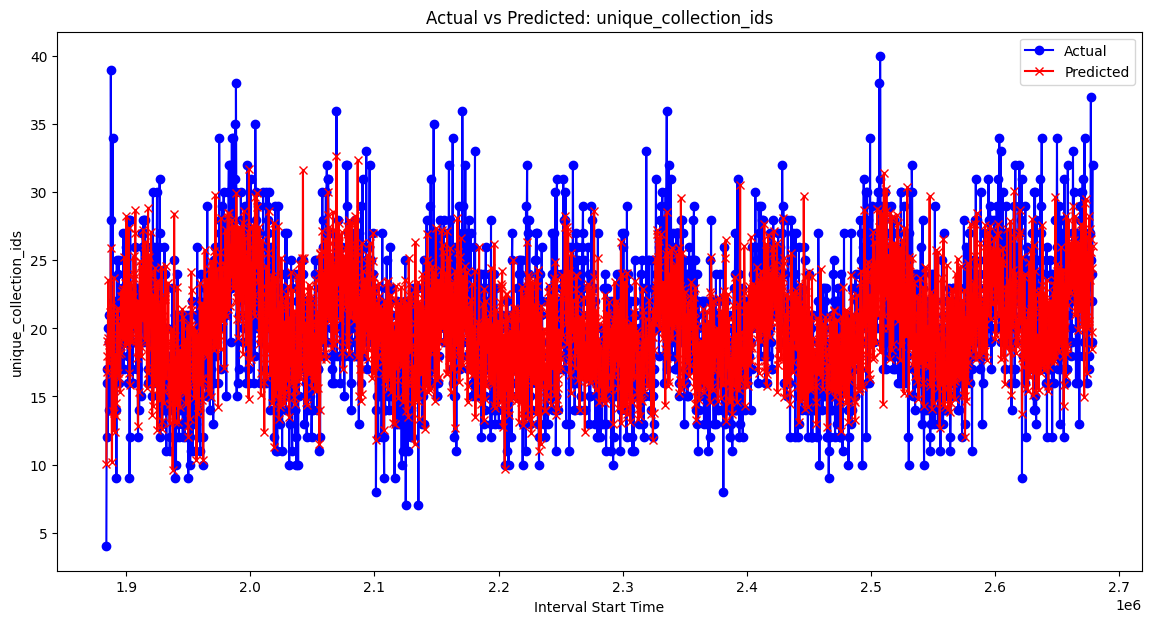

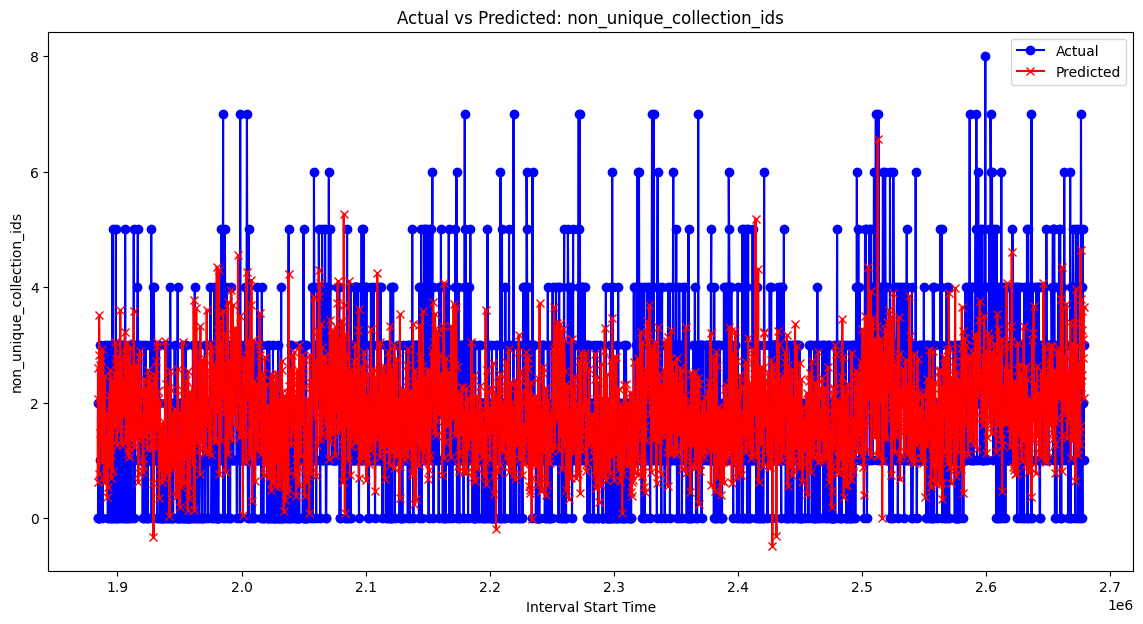

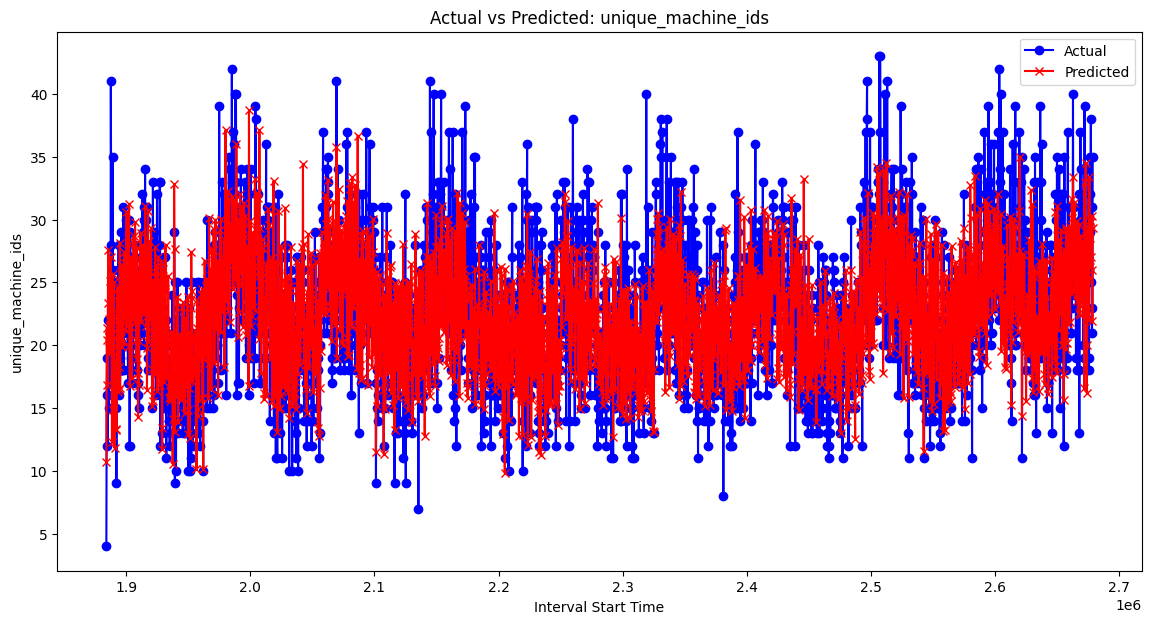

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load Dataset extracted from BigQuery
file_path = "/home/nsmsc/merged_instance_usage_200k - new.csv"
data = pd.read_csv(file_path)

# Convert start and end times from microseconds to seconds
data['start_time'] = data['start_time'] / 1e6
data['end_time'] = data['end_time'] / 1e6

# Sort data by start time
data = data.sort_values(by='start_time')

# Define the interval length 
interval_length = 300

def process_interval(interval_data):
    collection_id_counts = interval_data['collection_id'].value_counts()
    non_unique_collection_ids_count = collection_id_counts[collection_id_counts > 1].count()
    unique_collection_ids_count = interval_data['collection_id'].nunique()
    unique_machine_ids_count = interval_data['machine_id'].nunique()
    sum_avg_cpu = interval_data['average_usage.cpus'].sum()
    sum_avg_memory = interval_data['average_usage.memory'].sum()
    sum_max_cpu = interval_data['maximum_usage.cpus'].sum()
    sum_max_memory = interval_data['maximum_usage.memory'].sum()
    return {
        'interval_start': interval_data['start_time'].min(),
        'unique_collection_ids': unique_collection_ids_count,
        'non_unique_collection_ids': non_unique_collection_ids_count,
        'unique_machine_ids': unique_machine_ids_count,
        'sum_avg_cpu': sum_avg_cpu,
        'sum_avg_memory': sum_avg_memory,
        'sum_max_cpu': sum_max_cpu,
        'sum_max_memory': sum_max_memory
    }

def prepare_features(data):
    results = []
    start_time = data['start_time'].min()
    end_time = data['start_time'].max()
    current_start = start_time

    while current_start < end_time:
        current_end = current_start + interval_length
        interval_data = data[(data['start_time'] >= current_start) & (data['start_time'] < current_end)]
        if not interval_data.empty:
            interval_result = process_interval(interval_data)
            results.append(interval_result)
        current_start = current_end

    df = pd.DataFrame(results)
    return df

# Split the data into 70% training and 30% testing
train_data, test_data = train_test_split(data, test_size=0.3, shuffle=False)

# Prepare features for the training data
train_features = prepare_features(train_data)

# Prepare features for the testing data
test_features = prepare_features(test_data)


X_train = train_features.drop(columns=['unique_collection_ids', 'non_unique_collection_ids', 'unique_machine_ids', 'interval_start'])
y_train = train_features[['unique_collection_ids', 'non_unique_collection_ids', 'unique_machine_ids']]

# Initialize XGBoost models for each target
models = {}
for target in y_train.columns:
    models[target] = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
    models[target].fit(X_train, y_train[target])


X_test = test_features.drop(columns=['unique_collection_ids', 'non_unique_collection_ids', 'unique_machine_ids', 'interval_start'])
y_test = test_features[['unique_collection_ids', 'non_unique_collection_ids', 'unique_machine_ids']]


y_pred = pd.DataFrame()
for target in y_test.columns:
    y_pred[target] = models[target].predict(X_test)


result_df = pd.concat([test_features.reset_index(drop=True), y_pred.add_suffix('_pred')], axis=1)


def plot_actual_vs_predicted(result_df, actual_col, predicted_col, interval_col):
    plt.figure(figsize=(14, 7))
    plt.plot(result_df[interval_col], result_df[actual_col], label='Actual', marker='o', color='blue')
    plt.plot(result_df[interval_col], result_df[predicted_col], label='Predicted', marker='x', color='red')
    plt.title(f'Actual vs Predicted: {actual_col}')
    plt.xlabel('Interval Start Time')
    plt.ylabel(actual_col)
    plt.legend()
    plt.show()


plot_actual_vs_predicted(result_df, 'unique_collection_ids', 'unique_collection_ids_pred', 'interval_start')
plot_actual_vs_predicted(result_df, 'non_unique_collection_ids', 'non_unique_collection_ids_pred', 'interval_start')
plot_actual_vs_predicted(result_df, 'unique_machine_ids', 'unique_machine_ids_pred', 'interval_start')


In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)  # Mean Squared Error (MSE)
    rmse = np.sqrt(mse)  # Root Mean Squared Error (RMSE)
    mae = mean_absolute_error(y_true, y_pred)  # Mean Absolute Error (MAE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error (MAPE)
    accuracy = 100 - mape  # Accuracy Percentage

    return mse, rmse, mae, mape, accuracy


metrics = {}
for actual_col, predicted_col in zip(['unique_collection_ids', 'non_unique_collection_ids', 'unique_machine_ids'],
                                      ['unique_collection_ids_pred', 'non_unique_collection_ids_pred', 'unique_machine_ids_pred']):
    mse, rmse, mae, mape, accuracy = calculate_metrics(result_df[actual_col], result_df[predicted_col])
    metrics[actual_col] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Accuracy (%)': accuracy
    }


for target, metric_values in metrics.items():
    print(f"Metrics for {target}:")
    for metric_name, value in metric_values.items():
        print(f"  {metric_name}: {value}")
    print("\n")


Metrics for unique_collection_ids:
  MSE: 16.773484887411
  RMSE: 4.095544516594955
  MAE: 3.230563847163938
  MAPE: 16.842088876095744
  Accuracy (%): 83.15791112390426


Metrics for non_unique_collection_ids:
  MSE: 2.0231986741183654
  RMSE: 1.422391884860978
  MAE: 1.1223234572695604
  MAPE: inf
  Accuracy (%): -inf


Metrics for unique_machine_ids:
  MSE: 22.583655393608133
  RMSE: 4.752226361781195
  MAE: 3.7425718019593437
  MAPE: 17.53271865920785
  Accuracy (%): 82.46728134079216


